# Compute point source 2D centroid as a function of wavelength
In this notebook we show how to compute a point source 2D centroid in IFU coordinates (alpha,beta) as a function of wavelength. We do this on the detector image plane.

### Define path to data and set flags

### <font color='green'> --Modify following path to the folder where the miri_mrs_point_source_fringes folder resides </font>

In [1]:
user_dir = '/Users/ioannisa/Desktop/python/miri_mrs_point_source_fringes/'

### <font color='green'> --Choose if you wish to save plots (default is True) </font>

In [2]:
save_plots = True

### <font color='red'> --Do NOT change following paths </font>

In [3]:
datapath   = user_dir+'data/'
figurepath = user_dir+'figures/'
outputpath = user_dir+'output_files/'

In [4]:
import os
import itertools
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import sys
sys.path.append(user_dir)
from core.funcs import point_source_centroiding

In [5]:
%matplotlib notebook

### Preamble

### --MRS auxilliary data

In [6]:
band = '1A'
nslices = 21

### --Load distortion maps

In [7]:
d2cMaps = {'sliceMap':np.load(datapath+'sliceMap.npy'),
           'lambdaMap':np.load(datapath+'lambdaMap.npy'),
           'alphaMap':np.load(datapath+'alphaMap.npy'),
           'betaMap':np.load(datapath+'betaMap.npy'),
           'nslices':nslices}

### --Load data

In [8]:
sci_img = fits.open(datapath+'CV2_P0.fits')[1].data

### --Define spectral grid

In [9]:
lambmin = 4.88 # micron
lambmax = 5.75 # micron
lambcens = np.arange(lambmin,lambmax,(lambmax-lambmin)/1024. )
lambfwhms = np.ones(len(lambcens))*(2*(lambmax-lambmin)/1024.)

### 2D centroid analysis

### --Determine 2D centroid in each wavelength bin
This is done in three steps:
1. A rough centroid is determined by looking at which slice has the largest summed signal (that is the rough centroid in beta) and then averaging the alpha coordinates of the pixels with the largest signal in the slice (that is the rough centroid in alpha).
2. A refined centroid in alpha is determined by fitting a 1D Gaussian in each spectral bin on the detector in the slice with the largest summed signal. A refined centroid in beta is determined by fitting a Gaussian to the peak signal in all the slices in each spectral bin.
3. A refined centroid in alpha and beta is determined by fitting a 2D Gaussian to a point cloud. This uses the previous centroid estimates as input.  

DISCLAIMER!!! It is common that out of the 1024 bins, bins 0-20 and 960-1023 fail to converge. That is because of the optical distortions on the detector which make certain wavelengths fall outside of the detector in some slices (not all), thus the centroiding code fails.

In [10]:
sign_amp2D,alpha_centers2D,beta_centers2D,sigma_alpha2D,sigma_beta2D,bkg_amp2D = point_source_centroiding(band,sci_img,d2cMaps,spec_grid=[lambcens,lambfwhms],fit='2D')

STEP 1: Rough centroiding
Slice 11 has the largest summed flux
Source position: beta = 0.0arcsec, alpha = -0.05arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 31, 32, 33, 34, 35, 37, 38, 173, 174, 175, 176, 177, 178, 179, 312, 313, 323, 324, 325, 490, 491, 492, 493, 506, 507, 508, 509, 510, 511, 572, 573, 574, 575, 576, 581, 582, 583, 584, 585, 586, 587, 631, 632, 633, 634, 635, 636, 637, 1021, 1022, 1023]


### --Fit 4th order polynomials to the 2D centroid vs wavelength

In [11]:
popt_alpha = np.polyfit(lambcens[np.isfinite(alpha_centers2D)],alpha_centers2D[np.isfinite(alpha_centers2D)],4)
poly_alpha = np.poly1d(popt_alpha)

popt_beta  = np.polyfit(lambcens[np.isfinite(beta_centers2D)],beta_centers2D[np.isfinite(beta_centers2D)],4)
poly_beta  = np.poly1d(popt_beta)

### --Plot result

<IPython.core.display.Javascript object>


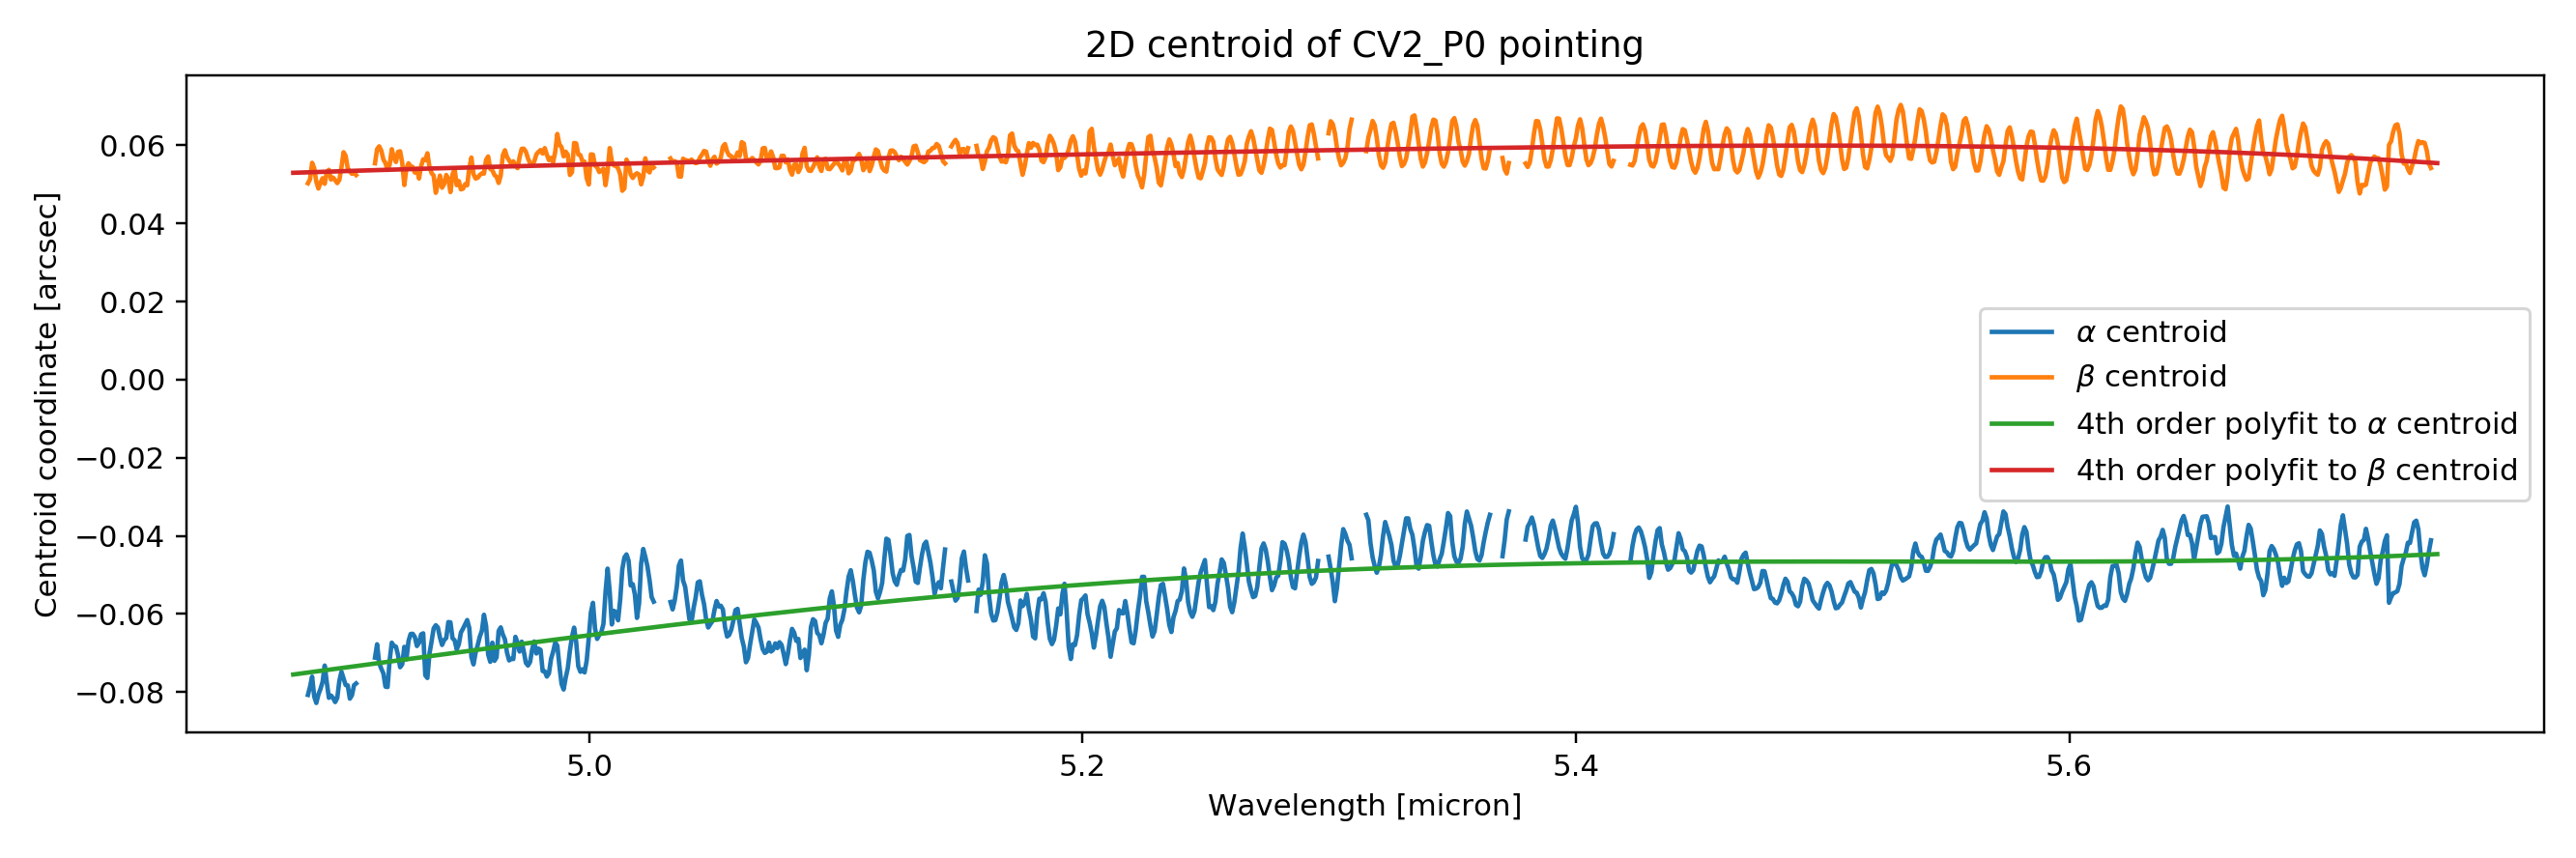

In [12]:
plt.figure(figsize=(12,4))
plt.plot(lambcens,alpha_centers2D,label=r'$\alpha$ centroid')
plt.plot(lambcens,beta_centers2D,label=r'$\beta$ centroid')
plt.plot(lambcens,poly_alpha(lambcens),label=r'4th order polyfit to $\alpha$ centroid')
plt.plot(lambcens,poly_beta(lambcens),label=r'4th order polyfit to $\beta$ centroid')
plt.title('2D centroid of CV2_P0 pointing')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Centroid coordinate [arcsec]')
plt.legend()
plt.tight_layout()
plt.savefig(figurepath+'2D_centroid_result.png')

### --Remarks: 
* The low frequency (rather peculiar) modulation in the alpha centroid is a result of the spatial undersampling of the source in MRS channel 1. This effect diminishes in channel 2 and beyond. The effect can be resolved by combining dither pointings (not done here).
* Fringing affects the point source centroid estimation. More specifically in band 1A the pixel subtended angle is approximately 0.196 arcseconds, and we measure a peak-to-peak variation of 0.01 arcseconds in alpha. This suggests an error of 5% of a pixel.

## Final statement: Due to the optical distortions, it is likely that a (small) systematic offset in the point source centroids versus wavelength will always be present in the data. By using the 4th order polynomial fits on the centroids, this systematic can be mitigated.

### --Store centroid result

In [13]:
np.save(outputpath+'lambcens',lambcens)
np.save(outputpath+'CV2_P0_alpha_cen_polyfit',popt_alpha)
np.save(outputpath+'CV2_P0_beta_cen_polyfit',popt_beta)